# Precios de automóviles

Servicio para la venta de coches con kilometraje "No bit, no pintado" desarrolla una aplicación para atraer nuevos clientes. Usted puede aprender rápidamente el valor de mercado de su coche. Usted tiene a su disposición los datos históricos: especificaciones, especificaciones y precios de coches. Es necesario construir un modelo para determinar el costo. 

Importante para el cliente:

- calidad de la predicción;
- la velocidad de predicción;
- tiempo de formación.

## Preparación de datos

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from catboost import CatBoostRegressor
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import make_scorer, mean_squared_error 
from sklearn.model_selection import cross_val_score, GridSearchCV , train_test_split 
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor 

In [2]:
import warnings
warnings.filterwarnings("ignore") 

In [3]:
try:
    data = pd.read_csv('/Applications/Python/autos.csv') 
except:
    data = pd.read_csv('/datasets/autos.csv')

In [4]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


**Descripciones de las columnas:**  
DateCrawled - fecha de descarga del cuestionario de la base de datos  
VehicleType - tipo de carrocería  
RegistratioAño - año de matriculación  
Caja de cambios - tipo de caja de cambios  
Potencia - potencia (l. p.)  
Modelo - modelo de coche  
Kilómetro - kilometraje (km)  
RegistrationMonth - el mes de matriculación  
FuelType - tipo de combustible  
Marca - marca de automóviles  
Reparado - era el coche en la reparación o no  
DateCreated - fecha de creación del cuestionario  
NumberOfPictures - número de fotos de coches  
PostalCode - código postal del propietario del cuestionario (usuario)  
LastSeen - fecha de la última actividad del usuario  
Precio - precio (euro) - función objetivo

In [5]:
data.columns = data.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [7]:
print('Количество дубликатов -', data.duplicated().sum())

Количество дубликатов - 4


In [8]:
data = data.drop_duplicates()
print('Количество дубликатов -', data.duplicated().sum())

Количество дубликатов - 0


In [9]:
# Deshágase de las columnas que no afectan el precio:

data.drop(columns=['date_crawled', 'date_created', 'number_of_pictures',
                    'postal_code', 'last_seen', 'registration_month'],
           axis=1,
           inplace=True)

In [10]:
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [11]:
print('Количество пропусков:')
display(data.isna().sum())

Количество пропусков:


price                    0
vehicle_type         37490
registration_year        0
gearbox              19833
power                    0
model                19705
kilometer                0
fuel_type            32895
brand                    0
repaired             71154
dtype: int64

In [12]:
# Veamos qué modelos se presentan en absoluto:

print(data['model'].unique())

['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore' 's_max' 'a2' 'galaxy' 'c3' 'viano' 's_klasse'
 '1_reihe' 'avensis' 'roomster' 'sl' 'kaefer' 'santa' 'cooper' 'leon'
 '4

In [13]:
# Porque. entre los valores hay otros - otros, utilizarlo para llenar los espacios en blanco.

data['model'] = data['model'].fillna('other')

In [14]:
# Omisiones en la caja de cambios de columnas (tipo de caja de cambios) y reparado (estaba en la reparación) lleno de valor desconocido - desconocido

data['gearbox'] = data['gearbox'].fillna('unknown')
data['repaired'] = data['repaired'].fillna('unknown')

In [15]:
# Las omisiones en las columnas Tipo de vehículo (tipo de carrocería) y Tipo de combustible (tipo de combustible) deben coincidir con los valores de las mismas filas. Rellene la función:

def type_filling_func(dataframe, model_column, type_column):
    model_list = list(dataframe[model_column].unique())
    type_list = []
    for i in model_list:
        type_list.append(list(dataframe.loc[dataframe.loc[:,model_column] == i][type_column].mode())[0])
    model_dict = dict(zip(model_list, type_list))
    
    for i in model_dict:
        dataframe.loc[dataframe.loc[:,model_column] == i] = dataframe.loc[dataframe.loc[:,model_column] == i].fillna(model_dict[i])

In [16]:
type_filling_func(data, 'model', 'vehicle_type')
type_filling_func(data, 'model', 'fuel_type')

In [17]:
display(data.isna().sum())

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

In [18]:
display(data.describe())

,price,registration_year,power,kilometer
count,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989
std,4514.176349,90.228466,189.851330,37905.083858
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


In [19]:
# Deshacerse de ceros en el signo de destino Precio

data.price.value_counts()

0        10772
500       5670
1500      5394
1000      4648
1200      4594
         ...  
1368         1
233          1
11080        1
16340        1
10985        1
Name: price, Length: 3731, dtype: int64

In [20]:
data = data.query('price > 0')

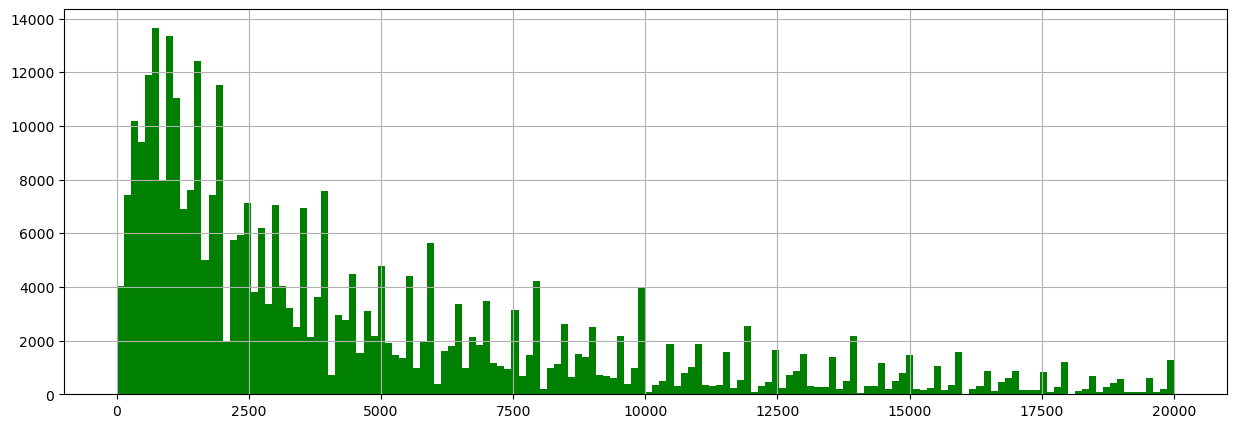

In [21]:
# Construyamos un histograma para asegurarnos de que la distribución de precios sea adecuada

data.price.hist(bins=150, figsize=(15,5), color='green');

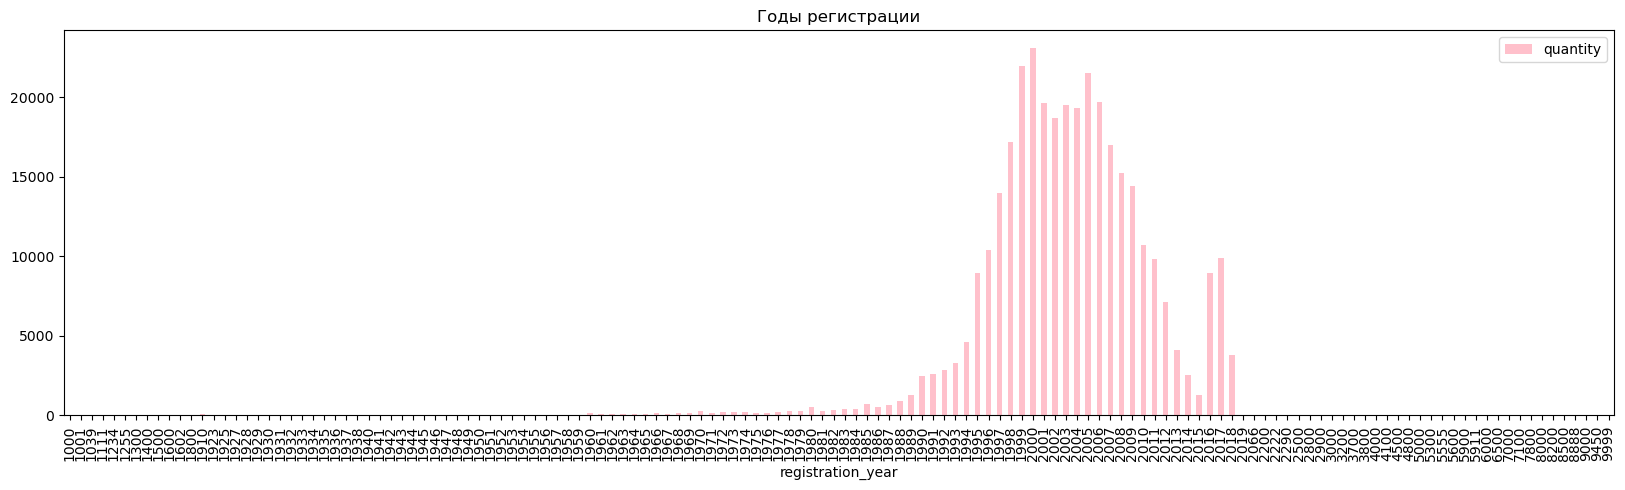

In [22]:
# Estudiar los valores de la fecha de registro

years = data.pivot_table(index='registration_year', values='brand', aggfunc='count')
years.columns = ['quantity']
years.plot.bar(figsize = (20,5), color='pink')
plt.title('Годы регистрации')
plt.show()

In [23]:
# Eliminar valores por debajo de 1980 y por encima de 2018 - son insignificantes, y la mayoría de ellos son simplemente irreales

data = data.query('1980 <= registration_year <= 2018')

In [24]:
# En la columna Potencia (potencia del motor) dejamos valores entre 10 y 1000

data = data.query('10 <= power <= 1000')

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304492 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              304492 non-null  int64 
 1   vehicle_type       304492 non-null  object
 2   registration_year  304492 non-null  int64 
 3   gearbox            304492 non-null  object
 4   power              304492 non-null  int64 
 5   model              304492 non-null  object
 6   kilometer          304492 non-null  int64 
 7   fuel_type          304492 non-null  object
 8   brand              304492 non-null  object
 9   repaired           304492 non-null  object
dtypes: int64(4), object(6)
memory usage: 25.6+ MB


### Revisión

Nos deshicimos de columnas innecesarias, duplicados eliminados y anomalías.
La carga se redujo en un 15%, pero la cantidad de datos (304k filas) es suficiente para aprender el modelo.

## Formación

In [26]:
features = data.drop('price', axis=1)
target = data['price']
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

In [27]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(228369, 9)
(76123, 9)
(228369,)
(76123,)


In [28]:
features_train_ohe = features_train.copy()
features_test_ohe = features_test.copy()
ohe_features_ridge = ['vehicle_type','gearbox','fuel_type','brand','model','repaired']
num_features = ['registration_year','power','kilometer'] #features_train.select_dtypes(exclude='object').columns.to_list()

In [29]:
# característica ya está reparado binario, no será codificado/ escalado
# add rest='passthrough para evitar que desaparezca

col_transformer_ridge = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        ohe_features_ridge
    ),
    (
        StandardScaler(), 
        num_features
    ),
    remainder='passthrough',
    verbose_feature_names_out=False
)

features_train_ohe = pd.DataFrame.sparse.from_spmatrix(
    col_transformer_ridge.fit_transform(features_train_ohe),
    columns=col_transformer_ridge.get_feature_names_out()
)

features_test_ohe = pd.DataFrame.sparse.from_spmatrix(
    col_transformer_ridge.transform(features_test_ohe),
    columns=col_transformer_ridge.get_feature_names_out()
)

target_train_ohe = target_train.copy()
target_test_ohe = target_test.copy()

In [30]:
encoder = OrdinalEncoder()

features_train_oe = features_train[['vehicle_type','fuel_type','brand','model']]
features_train_oe = pd.DataFrame(encoder.fit_transform(features_train),
                                 columns=features_train.columns,
                                 index=features_train.index)

features_test_oe = features_test[['vehicle_type','fuel_type','brand','model']]
features_test_oe = pd.DataFrame(encoder.fit_transform(features_test),
                                columns=features_test.columns,
                                index=features_test.index)

target_train_oe = target_train.copy()
target_test_oe = target_test.copy()

### Linear regression

In [31]:
%%time

# OneHotEncoder

model_lr = LinearRegression()
model_lr.fit(features_train_ohe, target_train_ohe)

CPU times: user 24.8 s, sys: 5.62 s, total: 30.5 s
Wall time: 4.15 s


LinearRegression()

In [32]:
%%time

target_predict = model_lr.predict(features_test_ohe)
rmse_lr_ohe = mean_squared_error(target_test_ohe, target_predict) ** .5
rmse_lr_ohe

CPU times: user 67.6 ms, sys: 25.8 ms, total: 93.3 ms
Wall time: 20.9 ms


2568.5789579724724

In [33]:
%%time

# OrdinalEncoder

model_lr = LinearRegression()
model_lr.fit(features_train_oe, target_train_oe)

CPU times: user 189 ms, sys: 92.3 ms, total: 282 ms
Wall time: 58.9 ms


LinearRegression()

In [34]:
%%time

target_predict = model_lr.predict(features_train_oe)
rmse_lr_oe = mean_squared_error(target_train_oe, target_predict) ** .5
rmse_lr_oe

CPU times: user 15.2 ms, sys: 9.59 ms, total: 24.8 ms
Wall time: 5.08 ms


2909.833078712961

In [35]:
%%time

model_lr = LinearRegression()
cvs_rmse_lr = (cross_val_score(model_lr,
                               features_train_oe,
                               target_train_oe,
                               cv=5,
                               scoring='neg_mean_squared_error')).mean() * -1 ** .5
cvs_rmse_lr

CPU times: user 589 ms, sys: 203 ms, total: 791 ms
Wall time: 132 ms


8468557.400954094

### CatBoostRegressor

In [36]:
%%time
cat_features = ['vehicle_type','gearbox','fuel_type','brand','model','repaired']
model_cbr = CatBoostRegressor(cat_features=cat_features) 
parameters = [{'learning_rate':[.1, .5, .8], 'random_state':[12345], 'verbose':[False]}]

gscv = GridSearchCV(model_cbr, parameters, scoring='neg_mean_squared_error')
gscv.fit(features_train, target_train)

print(gscv.best_params_)

mts = gscv.cv_results_['mean_test_score']
    
gscv_rsme_cbr_ohe = (max(mts) * -1) ** .5
gscv_rsme_cbr_ohe

{'learning_rate': 0.5, 'random_state': 12345, 'verbose': False}
CPU times: user 1h 2min 12s, sys: 2min 26s, total: 1h 4min 38s
Wall time: 11min 18s


1567.8156252877689

In [37]:
%%time

# Mejor valorado

model_cbr = CatBoostRegressor(learning_rate=.5, random_state=12345, verbose=False, cat_features=cat_features)
model_cbr.fit(features_train, target_train)

CPU times: user 4min 45s, sys: 9.56 s, total: 4min 54s
Wall time: 47.9 s


In [38]:
%%time

target_predict = model_cbr.predict(features_test)
rmse_cbr = mean_squared_error(target_test, target_predict) ** .5
rmse_cbr

CPU times: user 752 ms, sys: 29.9 ms, total: 782 ms
Wall time: 203 ms


1557.8040349909807

In [39]:
%%time

# OrdinalEncoder

model_cbr = CatBoostRegressor() 
parameters = [{'learning_rate':[.1, .5, .8], 'random_state':[12345], 'verbose':[False]}]

gscv = GridSearchCV(model_cbr, parameters, scoring='neg_mean_squared_error')
gscv.fit(features_train_oe, target_train_oe)

print(gscv.best_params_)

mts = gscv.cv_results_['mean_test_score']
    
gscv_rsme_cbr_oe = (max(mts) * -1) ** .5
gscv_rsme_cbr_oe

{'learning_rate': 0.5, 'random_state': 12345, 'verbose': False}
CPU times: user 8min 49s, sys: 1min 20s, total: 10min 9s
Wall time: 2min 5s


1558.4445335072332

In [40]:
%%time

# Mejores parámetros

model_cbr = CatBoostRegressor(learning_rate=.5, random_state=12345, verbose=False) 
model_cbr.fit(features_train_oe, target_train_oe)

CPU times: user 38.1 s, sys: 4.37 s, total: 42.4 s
Wall time: 10.8 s


In [41]:
%%time

target_predict = model_cbr.predict(features_test_oe)
rmse_cbr_oe = mean_squared_error(target_test, target_predict) ** .5
rmse_cbr_oe

CPU times: user 84.8 ms, sys: 21.9 ms, total: 107 ms
Wall time: 73.5 ms


1696.4159006752843

### DecissionTree 

In [43]:
%%time

# OneHotEncoder

regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 10)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[12345]}]
print('# Настройка гиперпараметров для root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train_ohe, target_train)
print("Наилучший набор параметров:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_DTR_ohe = (max(means)*-1) ** 0.5
cv_RMSE_DTR_ohe

# Настройка гиперпараметров для root_mean_squared_error

Наилучший набор параметров:

{'criterion': 'mse', 'max_depth': 9, 'random_state': 12345}

Grid scores on development set:

3235.987233 for {'criterion': 'mse', 'max_depth': 2, 'random_state': 12345}
2940.183323 for {'criterion': 'mse', 'max_depth': 3, 'random_state': 12345}
2645.378218 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 12345}
2435.050687 for {'criterion': 'mse', 'max_depth': 5, 'random_state': 12345}
2281.707485 for {'criterion': 'mse', 'max_depth': 6, 'random_state': 12345}
2167.103779 for {'criterion': 'mse', 'max_depth': 7, 'random_state': 12345}
2086.373037 for {'criterion': 'mse', 'max_depth': 8, 'random_state': 12345}
2025.700780 for {'criterion': 'mse', 'max_depth': 9, 'random_state': 12345}

CPU times: user 1min 30s, sys: 675 ms, total: 1min 30s
Wall time: 1min 31s


2025.7007799274493

In [44]:
%%time

# Predicción de los mejores parámetros (método OHE)

model = DecisionTreeRegressor(criterion='mse', 
                              max_depth=9, 
                              random_state=12345) 
model.fit(features_train_ohe, target_train)

CPU times: user 1.59 s, sys: 13.5 ms, total: 1.6 s
Wall time: 1.62 s


DecisionTreeRegressor(criterion='mse', max_depth=9, random_state=12345)

In [45]:
%%time

# OrdinalEncoder

regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 10)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[12345]}]

print('# Настройка гиперпараметров для root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train_oe, target_train)
print("Наилучший набор параметров:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_DTR_ordinal = (max(means)*-1) ** 0.5
cv_RMSE_DTR_ordinal

# Настройка гиперпараметров для root_mean_squared_error

Наилучший набор параметров:

{'criterion': 'mse', 'max_depth': 9, 'random_state': 12345}

Grid scores on development set:

3235.987233 for {'criterion': 'mse', 'max_depth': 2, 'random_state': 12345}
2940.183323 for {'criterion': 'mse', 'max_depth': 3, 'random_state': 12345}
2644.043448 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 12345}
2431.638859 for {'criterion': 'mse', 'max_depth': 5, 'random_state': 12345}
2281.923095 for {'criterion': 'mse', 'max_depth': 6, 'random_state': 12345}
2161.692270 for {'criterion': 'mse', 'max_depth': 7, 'random_state': 12345}
2080.427062 for {'criterion': 'mse', 'max_depth': 8, 'random_state': 12345}
2013.472483 for {'criterion': 'mse', 'max_depth': 9, 'random_state': 12345}

CPU times: user 6.21 s, sys: 44.9 ms, total: 6.26 s
Wall time: 6.29 s


2013.4724828150881

In [46]:
%%time

# Predicción de los mejores parámetros (método OE)

model = DecisionTreeRegressor(criterion='mse', 
                              max_depth=9, 
                              random_state=12345) 
model.fit(features_train_oe, target_train)

CPU times: user 274 ms, sys: 1.5 ms, total: 276 ms
Wall time: 274 ms


DecisionTreeRegressor(criterion='mse', max_depth=9, random_state=12345)

## Análisis modelo

Presentemos los resultados como una tabla:

In [48]:
index = ['Линейная регрессия с OHE',
         'Линейная регрессия с OE',
         'CatBoostRegressor',
         'CatBoostRegressor с OE',
         'DecissionTree с OHE',
         'DecissionTree с OE'
        ]

data = {'RMSE':[rmse_lr_ohe,
                rmse_lr_oe,
                rmse_cbr,
                rmse_cbr_oe,
                cv_RMSE_DTR_ohe,
                cv_RMSE_DTR_ordinal],
        
        'Время обучения модели':[4.15,
                                 0.0589,
                                 47.9,
                                 10.8,
                                 91,
                                 6.29],
        
        'Время предсказания модели':[0.029,
                                     0.0058,
                                     0.203,
                                     0.0735,
                                     1.62,
                                     0.274]
       }

kpi_data = pd.DataFrame(data=data, index=index)

# Haga la columna con la calificación general:
kpi_data['Рейтинг'] = (kpi_data['RMSE'] * .34 \
                       + kpi_data['Время обучения модели'] * .33 \
                       + kpi_data['Время предсказания модели'] * .33)

kpi_data.sort_values(by = 'Рейтинг', ascending=True)

,RMSE,Время обучения модели,Время предсказания модели,Рейтинг
CatBoostRegressor,1557.804035,47.9000,0.2030,545.527362
CatBoostRegressor с OE,1696.415901,10.8000,0.0735,580.369661
DecissionTree с OE,2013.472483,6.2900,0.2740,686.746764
DecissionTree с OHE,2025.700780,91.0000,1.6200,719.302865
Линейная регрессия с OHE,2568.578958,4.1500,0.0290,874.695916
Линейная регрессия с OE,2909.833079,0.0589,0.0058,989.364598


El mejor momento para modelar la calidad fue CatBoostRegressor.

## Las mejores pruebas de modelos

El CatBoostRegressor resultó ser el mejor. Hagamos la prueba final.

In [49]:
features_train_fin, features_valid_fin, target_train_fin, target_valid_fin = train_test_split(features,
                                                                                            target,
                                                                                            test_size=.4,
                                                                                            random_state=12345)

features_test_fin, features_valid_fin, target_test_fin, target_valid_fin = train_test_split(features_valid_fin,
                                                                                            target_valid_fin,
                                                                                            test_size=0.5,
                                                                                            random_state=12345)

In [50]:
for i in [features_train_fin, features_valid_fin, features_test_fin, target_train_fin, target_valid_fin, target_test_fin]:
    print(i.shape)

(182695, 9)
(60899, 9)
(60898, 9)
(182695,)
(60899,)
(60898,)


In [51]:
%%time

model_cbr = CatBoostRegressor(learning_rate=.5, random_state=12345, verbose=False, cat_features=cat_features)
model_cbr.fit(features_train_fin, target_train_fin)

CPU times: user 3min 46s, sys: 9.47 s, total: 3min 56s
Wall time: 40.9 s


In [53]:
%%time

target_predict_fin = model_cbr.predict(features_valid_fin)
rmse_cbr_fin = mean_squared_error(target_valid_fin, target_predict_fin) ** .5
rmse_cbr_fin

CPU times: user 613 ms, sys: 93.4 ms, total: 706 ms
Wall time: 178 ms


1568.8157108994026

In [52]:
%%time

target_predict_fin = model_cbr.predict(features_test_fin)
rmse_cbr_fin = mean_squared_error(target_test_fin, target_predict_fin) ** .5
rmse_cbr_fin

CPU times: user 604 ms, sys: 79.7 ms, total: 684 ms
Wall time: 197 ms


1577.4251913093067

## Retirada

Como resultado del proyecto, descargamos los datos, los analizamos y los convertimos.  
Se compararon 3 modelos con diferentes hiperparámetros y muestras.  
Como resultado, se eligió el mejor modelo, basado en RMSE, tiempo de aprendizaje y tiempo de predicción.  
El resultado - el mejor modelo de CatBoostRegressor, asesoramos a su cliente.
Los resultados de la prueba final confirmaron el experimento. RMSE = 1577, tiempo de aprendizaje con los mejores parámetros = 40 segundos, tiempo de predicción 178 milímetros.